# <center>**Build Clean Dataset**</center>  
**Author**: Shirshak Aryal  
**Last Updated**: 18 July 2025

---

**Purpose:** This notebook establishes a connection to the locally saved ChEMBL SQLite database, performs specific queries to extract and join relevant bioactivity data, and executes initial cleaning steps, including the transformation of `GI50` values to the more suitable `pGI50` scale (`-log10(GI50)`). The resulting clean and preprocessed dataset is then saved locally for subsequent use in feature engineering and model development.  

------

## 1. Setup Notebook
This section initializes the notebook environment by configuring system settings and importing necessary libraries.

### 1.1. Configure Environment
This subsection sets environment variables for optimizing CPU core usage in numerical libraries.

In [3]:
# General CPU Usage Optimization
import os
os.environ['OMP_NUM_THREADS'] = '16'
os.environ['MKL_NUM_THREADS'] = '16'
os.environ['OPENBLAS_NUM_THREADS'] = '16'
os.environ['NUMEXPR_NUM_THREADS'] = '16'

### 1.2. Import Libraries
All required Python libraries are imported here, logically grouped and ordered.

In [4]:
# Standard Library Imports
import sqlite3
from pathlib import Path

# Core Data Science Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Utility Libraries
from IPython.display import Image, display  # For displaying images in notebooks

## 2. Prepare Dataset
This section outlines the steps taken to extract, inspect, and combine the necessary raw data from the CHEMBL SQLite database, preparing it for subsequent cleaning and feature engineering.

### 2.1. Load Database Schema Image
A visual representation of the ChEMBL database schema is loaded and displayed to provide a comprehensive overview of the database structure, aiding in identifying relevant tables for querying.

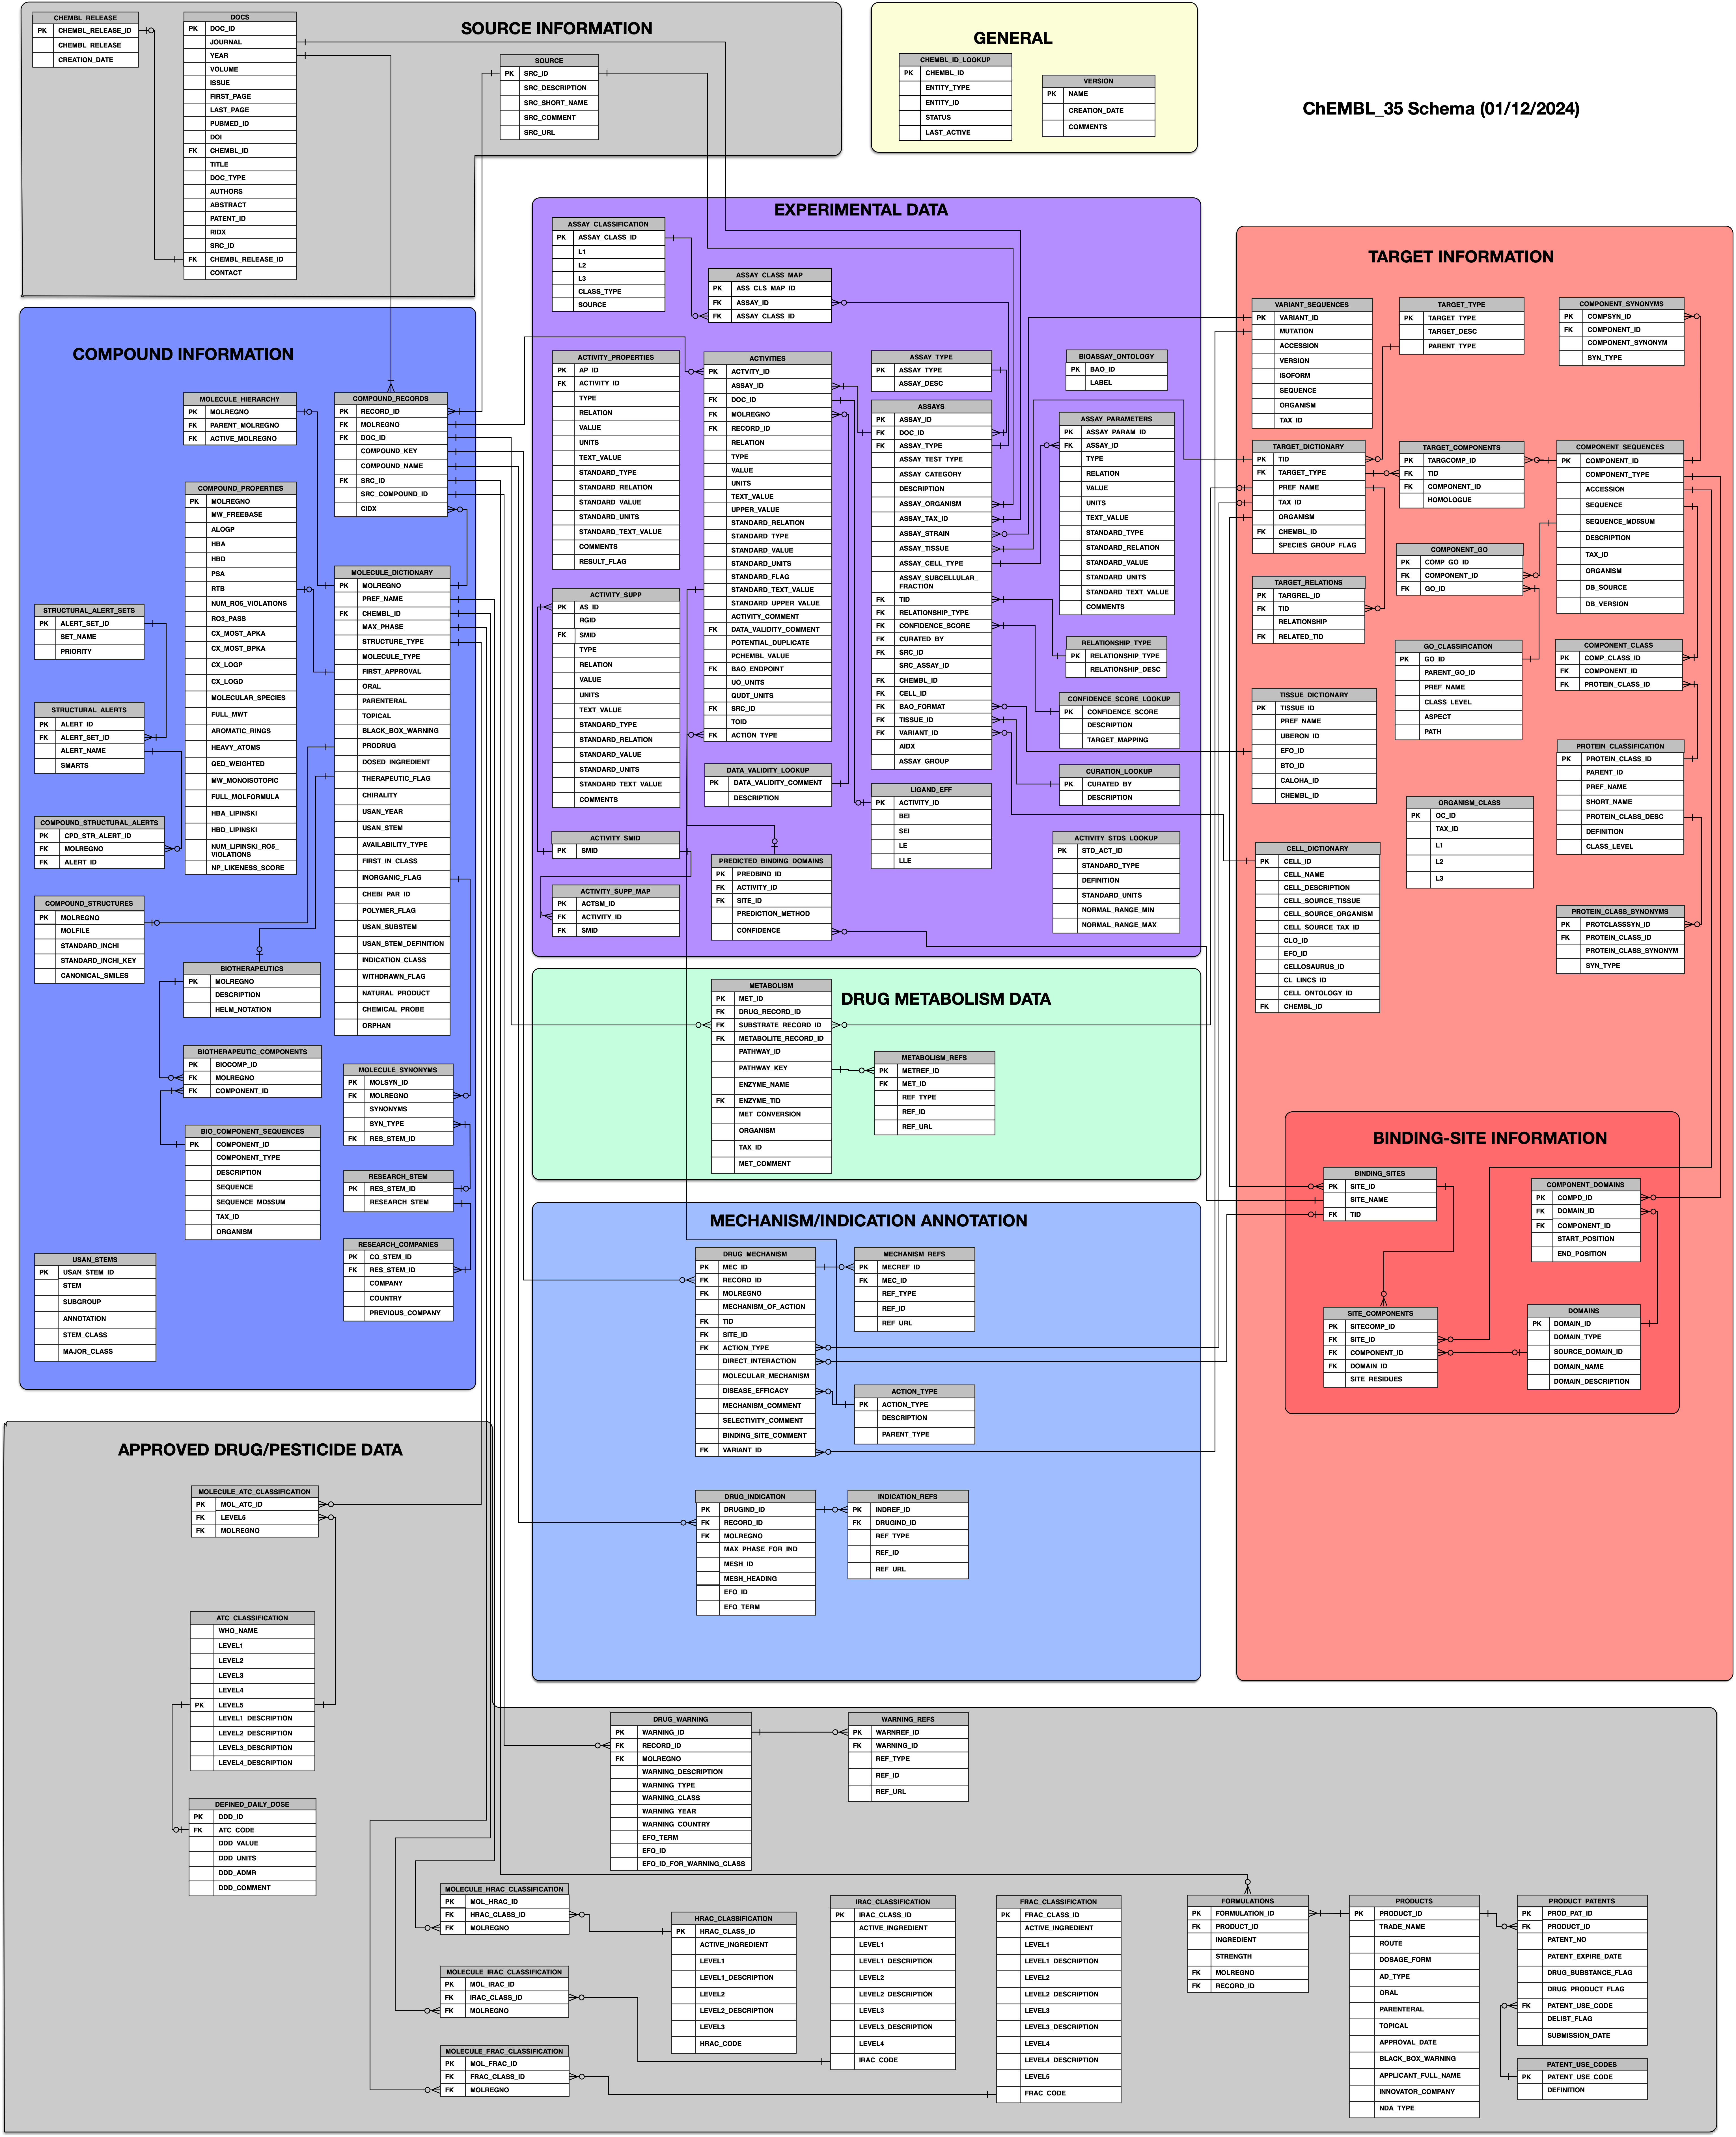

In [6]:
display(Image(filename="../data/chembl_35_schema.png"))

### 2.2. Inspect ChEMBL Tables
This subsection involves preliminary inspection of all raw ChEMBL database tables to understand their content, columns, and relationships before executing specific data extraction queries.

In [8]:
# Database file path
chembl_db_path = Path("../data/raw/chembl_35_sqlite/chembl_35/chembl_35_sqlite/chembl_35.db")

In [9]:
# Connect and inspect
try:
    global conn # Declare conn as global to ensure it's accessible in other cells
    conn = sqlite3.connect(chembl_db_path)
    cursor = conn.cursor()
    print(f"Successfully connected to database: {chembl_db_path}")
    print("-" * 60)

    # Get all table names
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name ASC;")
    all_tables = cursor.fetchall()

    print(f"Found {len(all_tables)} tables in the database. Displaying first 3 rows for each:")
    print("-" * 60)

    # Display first few rows from each table
    for table_name_tuple in all_tables:
        table_name = table_name_tuple[0] # Extract the table name string from the tuple
        print(f"Table: {table_name}")
        try:
            df_sample = pd.read_sql_query(f"SELECT * FROM {table_name} LIMIT 3;", conn)
            display(df_sample)
        except Exception as e:
            print(f"    Error reading table {table_name}: {e}")
        print("\n")
    print("=" * 60 + "\n")

except FileNotFoundError:
    print(f"Error: Database file not found at {chembl_db_path}. Please ensure the path is correct.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully connected to database: ..\data\raw\chembl_35_sqlite\chembl_35\chembl_35_sqlite\chembl_35.db
------------------------------------------------------------
Found 80 tables in the database. Displaying first 3 rows for each:
------------------------------------------------------------
Table: action_type


action_type                                        description  \
0              ACTIVATOR  Positively effects the normal functioning of t...   
1                AGONIST  Binds to and activates a receptor, often mimic...   
2  ALLOSTERIC ANTAGONIST  Binds to a receptor at an allosteric site and ...   

          parent_type  
0  POSITIVE MODULATOR  
1  POSITIVE MODULATOR  
2  NEGATIVE MODULATOR



Table: activities


activity_id  assay_id  doc_id  record_id  molregno standard_relation  \
0        31863     54505    6424     206172    180094                 >   
1        31864     83907    6432     208970    182268                 =   
2        31865     88152    6432     208970    182268                 >   

   standard_value standard_units  standard_flag standard_type  ...  \
0          100000             nM              1          IC50  ...   
1            2500             nM              1          IC50  ...   
2           50000             nM              1          IC50  ...   

  upper_value standard_upper_value  src_id  type relation  value units  \
0        None                 None       1  IC50        >  100.0    uM   
1        None                 None       1  IC50        =    2.5    uM   
2        None                 None       1  IC50        >   50.0    uM   

  text_value standard_text_value action_type  
0       None                None        None  
1       None                None        None  
2       None                None        None  

[3 rows x 28 columns]



Table: activity_properties


ap_id  activity_id           type relation value units          text_value  \
0      1     17126237        DATASET     None  None  None          Hematology   
1      2     17126237  ACTIVITY_TEST     None  None  None  RBC (Erythrocytes)   
2      3     17126237         TISSUE     None  None  None               Blood   

   standard_type standard_relation standard_value standard_units  \
0        DATASET              None           None           None   
1  ACTIVITY_TEST              None           None           None   
2         TISSUE              None           None           None   

  standard_text_value comments  result_flag  
0          Hematology     None            0  
1  RBC (Erythrocytes)     None            0  
2               Blood     None            0



Table: activity_smid


smid
0     1
1     2
2     3



Table: activity_stds_lookup


std_act_id standard_type                                        definition  \
0           1          CC50       Concentration required for 50% cytotoxicity   
1           2          EC50          Effective concentration for 50% activity   
2           3          GI50  Concentration required for 50% growth inhibition   

  standard_units  normal_range_min  normal_range_max  
0             nM              1.00          10000000  
1             nM              0.01            100000  
2             nM              1.00          10000000



Table: activity_supp


as_id  rgid     smid                                    type relation  \
0      1     1  1012613    Liver_Deposit, glycogen (Peripheral)     None   
1      2     2  1012614    Liver_Deposit, glycogen (Peripheral)     None   
2      3     3  1012615  Liver_Degeneration, fatty (Peripheral)     None   

  value units text_value                           standard_type  \
0  None  None     slight    Liver_Deposit, glycogen (Peripheral)   
1  None  None     slight    Liver_Deposit, glycogen (Peripheral)   
2  None  None     slight  Liver_Degeneration, fatty (Peripheral)   

  standard_relation standard_value standard_units standard_text_value  \
0              None           None           None              slight   
1              None           None           None              slight   
2              None           None           None              slight   

                                            comments  
0  SAMPLE_ID: 0698011; SP_FLG: true; BARCODE: No ...  
1  SAMPLE_ID: 0698025; SP_FLG: true; BARCODE: No ...  
2  SAMPLE_ID: 0698051; SP_FLG: false; BARCODE: 00...



Table: activity_supp_map


actsm_id  activity_id  smid
0         1     17126840  2938
1         2     17126841  2939
2         3     17126842  2940



Table: assay_class_map


ass_cls_map_id  assay_id  assay_class_id
0         2526021    585237             344
1         2526022    511570             344
2         2526023    511565             344



Table: assay_classification


assay_class_id                               l1                     l2  \
0               1  ALIMENTARY TRACT AND METABOLISM  Anti-Obesity Activity   
1               2  ALIMENTARY TRACT AND METABOLISM  Anti-Obesity Activity   
2               3  ALIMENTARY TRACT AND METABOLISM  Anti-Obesity Activity   

                                                  l3        class_type  \
0  Computer-Assisted Measurement of Food Consumpt...  In vivo efficacy   
1        Food Consumption in Rats Anorectic Activity  In vivo efficacy   
2                      General Anti-Obesity activity  In vivo efficacy   

       source  
0  Vogel_2008  
1  Vogel_2008  
2   phenotype



Table: assay_parameters


assay_param_id  assay_id                  type relation  value units  \
0         3710880   1640162          assay_method     None    NaN  None   
1         3710881   1640162  data_collection_rate     None   10.0    Hz   
2         3710882   1640162         fitting_model     None    NaN  None   

             text_value         standard_type standard_relation  \
0                   SPR          assay_method              None   
1                  None  data_collection_rate              None   
2  1:1 + mass transport         fitting_model              None   

   standard_value standard_units   standard_text_value comments  
0             NaN           None                   SPR     None  
1            10.0             Hz                  None     None  
2             NaN           None  1:1 + mass transport     None



Table: assay_type


assay_type  assay_desc
0          A        ADME
1          B     Binding
2          F  Functional



Table: assays


assay_id  doc_id                                        description  \
0         1   11087  The compound was tested for the in vitro inhib...   
1         2     684  Compound was evaluated for its ability to mobi...   
2         3   15453                                               None   

  assay_type assay_test_type assay_category assay_organism assay_tax_id  \
0          B            None           None           None         None   
1          F            None           None           None         None   
2          B            None           None           None         None   

  assay_strain assay_tissue  ...    curated_by src_id  src_assay_id  \
0         None         None  ...  Autocuration      1          None   
1         None         None  ...  Autocuration      1          None   
2         None         None  ...  Autocuration      1          None   

      chembl_id  cell_id   bao_format  tissue_id variant_id  aidx assay_group  
0  CHEMBL615117     None  BAO_0000019       None       None  CLD0        None  
1  CHEMBL615118     None  BAO_0000219       None       None  CLD0        None  
2  CHEMBL615119     None  BAO_0000019       None       None  CLD0        None  

[3 rows x 25 columns]



Table: atc_classification


who_name level1 level2 level3 level4   level5  \
0             sodium fluoride      A    A01   A01A  A01AA  A01AA01   
1  sodium monofluorophosphate      A    A01   A01A  A01AA  A01AA02   
2                     olaflur      A    A01   A01A  A01AA  A01AA03   

                level1_description           level2_description  \
0  ALIMENTARY TRACT AND METABOLISM  STOMATOLOGICAL PREPARATIONS   
1  ALIMENTARY TRACT AND METABOLISM  STOMATOLOGICAL PREPARATIONS   
2  ALIMENTARY TRACT AND METABOLISM  STOMATOLOGICAL PREPARATIONS   

            level3_description          level4_description  
0  STOMATOLOGICAL PREPARATIONS  Caries prophylactic agents  
1  STOMATOLOGICAL PREPARATIONS  Caries prophylactic agents  
2  STOMATOLOGICAL PREPARATIONS  Caries prophylactic agents



Table: binding_sites


site_id                                          site_name     tid
0        2     UDP-glucuronosyltransferase 1-10, UDPGT domain  104088
1        3  Mitogen-activated protein kinase 8, Pkinase do...  104254
2        4  Inosine-5'-monophosphate dehydrogenase 1, IMPD...      84



Table: bio_component_sequences


component_id component_type description                   sequence  \
0         20525        PROTEIN        None       FPRPGGGGNGDFEEIPEEYL   
1         20526        PROTEIN        None                      NDWFL   
2         20527        PROTEIN        None  CKGSRCSGTCCDYMLRSCKAGKGKC   

                    sequence_md5sum tax_id organism  
0  a0452532fb71718ad277e1960804bba5   None     None  
1  3b57e34fe0eb7bdf38b9234170196f72   None     None  
2  db7f8b4c577d369c4a2796758b316cb9   None     None



Table: bioassay_ontology


bao_id                 label
0  BAO_0000006  percent cytotoxicity
1  BAO_0000007     nucleosome format
2  BAO_0000008         bioassay type



Table: biotherapeutic_components


biocomp_id  molregno  component_id
0        1240   2039327         22397
1        1241   2039248         21130
2        1242   2039248         21131



Table: biotherapeutics


molregno description                             helm_notation
0       197        None        PEPTIDE1{A.L.Y.A.S.K.L.S.[am]}$$$$
1       326        None         PEPTIDE1{[meR].K.P.W.[Tle].L}$$$$
2       364        None  PEPTIDE1{[X833].[dP].W.[Tle].[X454]}$$$$



Table: cell_dictionary


cell_id cell_name cell_description   cell_source_tissue  \
0        1      DC3F             DC3F                 Lung   
1        2    P3HR-1           P3HR-1              Lyphoma   
2        3  UCLA P-3         UCLA P-3  Lung Adenocarcinoma   

  cell_source_organism  cell_source_tax_id       clo_id       efo_id  \
0   Cricetulus griseus               10029         None         None   
1         Homo sapiens                9606  CLO_0008331  EFO_0002312   
2         Homo sapiens                9606         None         None   

  cellosaurus_id cl_lincs_id      chembl_id cell_ontology_id  
0      CVCL_4704        None  CHEMBL3307241             None  
1      CVCL_2676    LCL-2024  CHEMBL3307242             None  
2      CVCL_N513        None  CHEMBL3307243             None



Table: chembl_id_lookup


chembl_id entity_type  entity_id  status  last_active
0    CHEMBL1    COMPOUND     517180  ACTIVE           35
1   CHEMBL10    COMPOUND        250  ACTIVE           35
2  CHEMBL100    COMPOUND      12356  ACTIVE           35



Table: chembl_release


chembl_release_id chembl_release               creation_date
0                  1       CHEMBL_1  2009-09-03 00:00:00.000000
1                  2       CHEMBL_2  2009-11-30 00:00:00.000000
2                  3       CHEMBL_3  2010-04-16 00:00:00.000000



Table: component_class


component_id  protein_class_id  comp_class_id
0             1              1173              1
1             2               422              2
2             3                12              3



Table: component_domains


compd_id  domain_id  component_id  start_position  end_position
0    490141       3658            47              38           241
1    490142       3658            48              42           249
2    490143       3658            49              39           242



Table: component_go


comp_go_id  component_id       go_id
0     2698228             1  GO:0016020
1     2698229             1  GO:0006810
2     2698230             1  GO:0003674



Table: component_sequences


component_id component_type accession  \
0             1        PROTEIN    O09028   
1             2        PROTEIN    P02708   
2             3        PROTEIN    P04637   

                                            sequence  \
0  MSYSLYLAFVCLNLLAQRMCIQGNQFNVEVSRSDKLSLPGFENLTA...   
1  MEPWPLLLLFSLCSAGLVLGSEHETRLVAKLFKDYSSVVRPVEDHR...   
2  MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...   

                    sequence_md5sum  \
0  7473be17a767c25bb1d57beee67ffff7   
1  c55fcab2ffecb6bac66c25960ddfe057   
2  c133dfce69f606f20865e9008199f852   

                                   description  tax_id           organism  \
0  Gamma-aminobutyric acid receptor subunit pi   10116  Rattus norvegicus   
1         Acetylcholine receptor subunit alpha    9606       Homo sapiens   
2                   Cellular tumor antigen p53    9606       Homo sapiens   

    db_source db_version  
0  SWISS-PROT    2024_05  
1  SWISS-PROT    2024_05  
2  SWISS-PROT    2024_05



Table: component_synonyms


compsyn_id  component_id component_synonym           syn_type
0      860862            48           Gabra-1  GENE_SYMBOL_OTHER
1      860867            49           Gabrb-3  GENE_SYMBOL_OTHER
2      860872            50           Gabrb-2  GENE_SYMBOL_OTHER



Table: compound_properties


molregno  mw_freebase  alogp  hba  hbd     psa  rtb ro3_pass  \
0         1       341.75   2.11    5    1   84.82    3        N   
1         2       332.32   1.33    6    1  108.61    3        N   
2         3       357.80   2.27    5    2   87.98    3        N   

   num_ro5_violations  cx_most_apka  ... full_mwt  aromatic_rings  \
0                   0          6.48  ...   341.75               3   
1                   0          6.33  ...   332.32               3   
2                   0          6.33  ...   357.80               3   

   heavy_atoms qed_weighted  mw_monoisotopic  full_molformula  hba_lipinski  \
0           24         0.74         341.0567     C17H12ClN3O3             6   
1           25         0.73         332.0909       C18H12N4O3             7   
2           25         0.75         357.0880     C18H16ClN3O3             6   

   hbd_lipinski  num_lipinski_ro5_violations np_likeness_score  
0             1                            0             -1.56  
1             1                            0             -1.59  
2             2                            0             -0.82  

[3 rows x 24 columns]



Table: compound_records


record_id  molregno  doc_id compound_key  \
0          1   1798298   11788            X   
1          2   1798410   11788            V   
2          3   1798299   11788           IX   

                                       compound_name  src_id src_compound_id  \
0  Bis(3-[14-Benzyl-11-(1H-indol-3-ylmethyl)-2-is...       1            None   
1  3-[11,14-Dibenzyl-2-isobutyl-5-(2-methylsulfan...       1            None   
2  3-[14-Benzyl-11-(1H-indol-3-ylmethyl)-2-isobut...       1            None   

   cidx  
0  CLD0  
1  CLD0  
2  CLD0



Table: compound_structural_alerts


cpd_str_alert_id  molregno  alert_id
0          79048021       103         1
1          79048022       105         1
2          79048023       638         1



Table: compound_structures


molregno                                            molfile  \
0         1  \n     RDKit          2D\n\n 24 26  0  0  0  0...   
1         2  \n     RDKit          2D\n\n 25 27  0  0  0  0...   
2         3  \n     RDKit          2D\n\n 25 27  0  0  0  0...   

                                      standard_inchi  \
0  InChI=1S/C17H12ClN3O3/c1-10-8-11(21-17(24)20-1...   
1  InChI=1S/C18H12N4O3/c1-11-8-14(22-18(25)21-16(...   
2  InChI=1S/C18H16ClN3O3/c1-10-7-14(22-18(25)21-1...   

            standard_inchi_key  \
0  OWRSAHYFSSNENM-UHFFFAOYSA-N   
1  ZJYUMURGSZQFMH-UHFFFAOYSA-N   
2  YOMWDCALSDWFSV-UHFFFAOYSA-N   

                                   canonical_smiles  
0      Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccccc1Cl  
1   Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(C#N)cc1  
2  Cc1cc(-n2ncc(=O)[nH]c2=O)cc(C)c1C(O)c1ccc(Cl)cc1



Table: confidence_score_lookup


confidence_score                                        description  \
0                 0  Default value - Target unknown or has yet to b...   
1                 1                   Target assigned is non-molecular   
2                 2            Target assigned is subcellular fraction   

         target_mapping  
0            Unassigned  
1         Non-molecular  
2  Subcellular fraction



Table: curation_lookup


curated_by                                        description
0  Autocuration        Curated against extractor target assignment
1        Expert  Curated against ChEMBL target assignment from ...
2  Intermediate  Curated against ChEMBL target assignment from ...



Table: data_validity_lookup


data_validity_comment  \
0      Author confirmed error   
1          Manually validated   
2  Non standard unit for type   

                                         description  
0  Error in publication - Author confirmed (perso...  
1  Data have been checked against the publication...  
2  Units for this activity type are unusual and m...



Table: defined_daily_dose


atc_code ddd_units ddd_admr ddd_comment  ddd_id  ddd_value
0  A01AA03        mg        O        None       2        1.1
1  A01AB02        mg        O        None       3       60.0
2  A01AB03        mg        O        None       4       30.0



Table: docs


doc_id     journal    year volume issue first_page last_page   pubmed_id  \
0      -1        None     NaN   None  None       None      None         NaN   
1       1  J Med Chem  2004.0     47     1          1         9  14695813.0   
2       2  J Med Chem  2004.0     47     1         10        13  14695814.0   

                 doi      chembl_id  \
0               None  CHEMBL1158643   
1  10.1021/jm030283g  CHEMBL1139451   
2  10.1021/jm034189b  CHEMBL1148466   

                                               title     doc_type  \
0                                Unpublished dataset      DATASET   
1  The discovery of ezetimibe: a view from outsid...  PUBLICATION   
2  Self-association of okadaic acid upon complexa...  PUBLICATION   

                                             authors  \
0                                               None   
1                                         Clader JW.   
2  Daranas AH, Fernández JJ, Morales EQ, Norte M,...   

                                            abstract patent_id  ridx  src_id  \
0                                               None      None  CLD0       0   
1                                               None      None  CLD0       1   
2  Okadaic acid (OA) is a toxin responsible for d...      None  CLD0       1   

   chembl_release_id contact  
0                  7    None  
1                  1    None  
2                  1    None



Table: domains


domain_id domain_type source_domain_id domain_name domain_description
0       2627      Pfam-A          PF00001       7tm_1               None
1       2628      Pfam-A          PF00002       7tm_2               None
2       2629      Pfam-A          PF00003       7tm_3               None



Table: drug_indication


drugind_id  record_id  molregno  max_phase_for_ind  mesh_id  \
0       22606    1390869    675774                  2  D045743   
1       22607    1390869    675774                  4  D001172   
2       22609    1343491    675576                  3  D009203   

            mesh_heading       efo_id               efo_term  
0   Scleroderma, Diffuse  EFO:0000404    diffuse scleroderma  
1  Arthritis, Rheumatoid  EFO:0000685   rheumatoid arthritis  
2  Myocardial Infarction  EFO:0000612  myocardial infarction



Table: drug_mechanism


mec_id  record_id  molregno               mechanism_of_action    tid  \
0      13    1343810      1124  Carbonic anhydrase VII inhibitor  11060   
1      14    1344053    675068    Carbonic anhydrase I inhibitor  10193   
2      15    1344649    674765    Carbonic anhydrase I inhibitor  10193   

  site_id action_type  direct_interaction  molecular_mechanism  \
0    None   INHIBITOR                   1                    1   
1    None   INHIBITOR                   1                    1   
2    None   INHIBITOR                   1                    1   

   disease_efficacy mechanism_comment selectivity_comment  \
0                 1              None                None   
1                 1              None                None   
2                 1  Expressed in eye                None   

  binding_site_comment variant_id  
0                 None       None  
1                 None       None  
2                 None       None



Table: drug_warning


warning_id  record_id  molregno       warning_type           warning_class  \
0           1    1343079   2341159  Black Box Warning          hepatotoxicity   
1           2    1343079   2341159  Black Box Warning      metabolic toxicity   
2           3    1343079   2341159  Black Box Warning  immune system toxicity   

  warning_description warning_country warning_year efo_term efo_id  \
0                None   United States         None     None   None   
1                None   United States         None     None   None   
2                None   United States         None     None   None   

  efo_id_for_warning_class  
0              EFO:0011052  
1              EFO:0011054  
2              EFO:0011053



Table: formulations


product_id                ingredient             strength  \
0  PRODUCT_072636_001         ALBUTEROL SULFATE          EQ 2MG BASE   
1  PRODUCT_062216_003               AMOXICILLIN                250MG   
2  PRODUCT_077260_002  IRINOTECAN HYDROCHLORIDE  100MG/5ML (20MG/ML)   

   record_id  molregno  formulation_id  
0    1343607    864943             347  
1    1343581    143284            1617  
2    1344312   2197385            1709



Table: frac_classification


frac_class_id active_ingredient level1                level1_description  \
0            470       PEFURAZOATE      G  STEROL BIOSYNTHESIS IN MEMBRANES   
1            471        PROCHLORAZ      G  STEROL BIOSYNTHESIS IN MEMBRANES   
2            472      TRIFLUMIZOLE      G  STEROL BIOSYNTHESIS IN MEMBRANES   

  level2                                 level2_description level3  \
0     G1  C14-DEMETHYLASE IN STEROL BIOSYNTHESIS (ERG11/...    G13   
1     G1  C14-DEMETHYLASE IN STEROL BIOSYNTHESIS (ERG11/...    G13   
2     G1  C14-DEMETHYLASE IN STEROL BIOSYNTHESIS (ERG11/...    G13   

                                  level3_description level4  \
0  DMI-FUNGICIDES (DEMETHYLATION INHIBITORS) (SBI...   G13D   
1  DMI-FUNGICIDES (DEMETHYLATION INHIBITORS) (SBI...   G13D   
2  DMI-FUNGICIDES (DEMETHYLATION INHIBITORS) (SBI...   G13D   

  level4_description level5 frac_code  
0         IMIDAZOLES  G13D3         3  
1         IMIDAZOLES  G13D4         3  
2         IMIDAZOLES  G13D5         3



Table: go_classification


go_id parent_go_id           pref_name  class_level aspect  \
0  GO:0000003   GO:0008150        reproduction            1      P   
1  GO:0000149   GO:0005515       SNARE binding            2      F   
2  GO:0000166   GO:0003674  nucleotide binding            1      F   

                                                path  
0                   biological_process  reproduction  
1  molecular_function  protein binding  SNARE bin...  
2             molecular_function  nucleotide binding



Table: hrac_classification


hrac_class_id     active_ingredient level1  \
0              1  CLODINAFOP-PROPARGYL      A   
1              2       CYHALOFOP-BUTYL      A   
2              3       DICLOFOP-METHYL      A   

                              level1_description level2  \
0  INHIBITION OF ACETYL COA CARBOXYLASE (ACCASE)     A1   
1  INHIBITION OF ACETYL COA CARBOXYLASE (ACCASE)     A1   
2  INHIBITION OF ACETYL COA CARBOXYLASE (ACCASE)     A1   

                 level2_description level3 hrac_code  
0  ARYLOXYPHENOXY-PROPIONATE 'FOPS'    A11         A  
1  ARYLOXYPHENOXY-PROPIONATE 'FOPS'    A12         A  
2  ARYLOXYPHENOXY-PROPIONATE 'FOPS'    A13         A



Table: indication_refs


indref_id  drugind_id        ref_type  \
0     593841      126883             FDA   
1     593843       22630             EMA   
2     593844       22630  ClinicalTrials   

                                              ref_id  \
0                       label/2015/205739s000lbl.pdf   
1                                    EMEA/H/C/002211   
2  NCT00358436,NCT00363896,NCT00435760,NCT0050031...   

                                             ref_url  
0  http://www.accessdata.fda.gov/drugsatfda_docs/...  
1  https://www.ema.europa.eu/en/medicines/human/E...  
2  https://clinicaltrials.gov/search?term=NCT0035...



Table: irac_classification


irac_class_id active_ingredient level1 level1_description level2  \
0              1       HEXYTHIAZOX      C  GROWTH REGULATION    C10   
1              2      DIFLOVIDAZIN      C  GROWTH REGULATION    C10   
2              3         ETOXAZOLE      C  GROWTH REGULATION    C10   

       level2_description  level3                       level3_description  \
0  MITE GROWTH INHIBITORS  C1010A  CLOFENTEZINE, HEXYTHIAZOX, DIFLOVIDAZIN   
1  MITE GROWTH INHIBITORS  C1010A  CLOFENTEZINE, HEXYTHIAZOX, DIFLOVIDAZIN   
2  MITE GROWTH INHIBITORS  C1010B                                ETOXAZOLE   

    level4 irac_code  
0  C1010A2       10A  
1  C1010A3       10A  
2  C1010B1       10B



Table: ligand_eff


activity_id    bei   sei    le   lle
0        31864  14.06  5.56  0.26  1.30
1        31866   9.69  4.23  0.18 -0.63
2        31868   9.94  6.93  0.20  1.13



Table: mechanism_refs


mecref_id  mec_id  ref_type                                      ref_id  \
0          2      13    PubMed                                    18336310   
1          3      13  DailyMed  setid=8e162b6d-8fa6-45f6-80d8-5132d94c1207   
2          4      14    PubMed                                     1460006   

                                             ref_url  
0         http://europepmc.org/abstract/MED/18336310  
1  http://dailymed.nlm.nih.gov/dailymed/lookup.cf...  
2          http://europepmc.org/abstract/MED/1460006



Table: metabolism


met_id  drug_record_id  substrate_record_id  metabolite_record_id  \
0     119         2468083              2468090               2468102   
1     120         2468083              2468083               2468093   
2     121         2468083              2468083               2468103   

   pathway_id   pathway_key enzyme_name enzyme_tid met_conversion  \
0           1  Fig. 2, p.19        None       None           None   
1           1  Fig. 2, p.19        None       None           None   
2           1  Fig. 2, p.19        None       None           None   

       organism  tax_id met_comment  
0  Homo sapiens    9606        None  
1  Homo sapiens    9606        None  
2  Homo sapiens    9606        None



Table: metabolism_refs


metref_id  met_id ref_type  \
0         39     119    OTHER   
1         40     120    OTHER   
2         41     121    OTHER   

                                              ref_id  \
0  http://www.accessdata.fda.gov/drugsatfda_docs/...   
1  http://www.accessdata.fda.gov/drugsatfda_docs/...   
2  http://www.accessdata.fda.gov/drugsatfda_docs/...   

                                             ref_url  
0  http://www.accessdata.fda.gov/drugsatfda_docs/...  
1  http://www.accessdata.fda.gov/drugsatfda_docs/...  
2  http://www.accessdata.fda.gov/drugsatfda_docs/...



Table: molecule_atc_classification


mol_atc_id   level5  molregno
0       91486  L04AA50    628156
1       91487  L01EA06   2286380
2       91488  L01EX15   2089491



Table: molecule_dictionary


molregno pref_name     chembl_id max_phase  therapeutic_flag  \
0         1      None    CHEMBL6329      None                 0   
1         2      None    CHEMBL6328      None                 0   
2         3      None  CHEMBL265667      None                 0   

   dosed_ingredient structure_type chebi_par_id   molecule_type  \
0                 0            MOL         None  Small molecule   
1                 0            MOL         None  Small molecule   
2                 0            MOL         None  Small molecule   

  first_approval  ...  usan_year  availability_type  usan_stem  polymer_flag  \
0           None  ...       None                 -1       None             0   
1           None  ...       None                 -1       None             0   
2           None  ...       None                 -1       None             0   

   usan_substem  usan_stem_definition  indication_class  withdrawn_flag  \
0          None                  None              None               0   
1          None                  None              None               0   
2          None                  None              None               0   

   chemical_probe orphan  
0               0     -1  
1               0     -1  
2               0     -1  

[3 rows x 29 columns]



Table: molecule_frac_classification


mol_frac_id  frac_class_id  molregno
0            1            579      6738
1            2            610    381700
2            3            480    440200



Table: molecule_hierarchy


molregno  parent_molregno  active_molregno
0         1                1                1
1         2                2                2
2         3                3                3



Table: molecule_hrac_classification


mol_hrac_id  hrac_class_id  molregno
0            1            271      4361
1            2            232     13437
2            3             96     16509



Table: molecule_irac_classification


mol_irac_id  irac_class_id  molregno
0            1            231       115
1            2             44      2812
2            3             91     65000



Table: molecule_synonyms


molregno       syn_type  molsyn_id  res_stem_id  synonyms
0        97  RESEARCH_CODE          1        152.0  CP-12299
1        97            FDA          4          NaN  Prazosin
2       115           USAN         11          NaN  Nicotine



Table: organism_class


oc_id  tax_id          l1             l2             l3
0      1   10030  Eukaryotes       Mammalia       Rodentia
1      2    9593  Eukaryotes       Mammalia       Primates
2      3     470    Bacteria  Gram-Negative  Acinetobacter



Table: patent_use_codes


patent_use_code                                         definition
0             U-1                            PREVENTION OF PREGNANCY
1            U-10  DIAGNOSTIC METHOD FOR DISTINGUISHING BETWEEN H...
2           U-100             METHOD OF TREATING OCULAR INFLAMMATION



Table: predicted_binding_domains


predbind_id  activity_id  site_id prediction_method confidence
0      7699241      1451903     1466     Single domain       high
1      7699242      1451927     1133     Single domain       high
2      7699243      1452215     1248     Single domain       high



Table: product_patents


prod_pat_id          product_id patent_no          patent_expire_date  \
0          257  PRODUCT_050805_001   8394406  2024-04-07 00:00:00.000000   
1          259  PRODUCT_050808_008   8268804  2025-06-24 00:00:00.000000   
2          260  PRODUCT_050808_007   7919483  2027-03-07 00:00:00.000000   

   drug_substance_flag  drug_product_flag patent_use_code  delist_flag  \
0                    0                  1           U-925            0   
1                    0                  0          U-1078            0   
2                    0                  0          U-1078            0   

              submission_date  
0  2013-03-25 00:00:00.000000  
1                        None  
2                        None



Table: products


dosage_form       route        trade_name               approval_date  \
0  SOLUTION/DROPS  OPHTHALMIC         PAREDRINE  1982-01-01 00:00:00.000000   
1          TABLET        ORAL     SULFAPYRIDINE  1982-01-01 00:00:00.000000   
2      INJECTABLE   INJECTION  LIQUAEMIN SODIUM  1982-01-01 00:00:00.000000   

  ad_type  oral  topical  parenteral black_box_warning applicant_full_name  \
0   DISCN     0        1           0              None        PHARMICS INC   
1   DISCN     1        0           0              None    ELI LILLY AND CO   
2   DISCN     0        0           1              None     ORGANON USA INC   

   innovator_company          product_id nda_type  
0                  0  PRODUCT_000004_004        N  
1                  0  PRODUCT_000159_001        N  
2                  0  PRODUCT_000552_001        N



Table: protein_class_synonyms


protclasssyn_id  protein_class_id protein_class_synonym      syn_type
0            33666                 1                Enzyme  CONCEPT_WIKI
1            33667                 1               Enzymes  CONCEPT_WIKI
2            33668                 1          Biocatalysts  CONCEPT_WIKI



Table: protein_classification


protein_class_id  parent_id      pref_name     short_name  \
0                 0        NaN  Protein class  Protein class   
1                 1        0.0         Enzyme         Enzyme   
2                 2        0.0       Adhesion       Adhesion   

  protein_class_desc                                         definition  \
0      protein class   Root of the ChEMBL protein family classification   
1             enzyme  Biological molecules that possess catalytic ac...   
2           adhesion  Surface ligands, usually glycoproteins, that m...   

   class_level  
0            0  
1            1  
2            1



Table: relationship_type


relationship_type                             relationship_desc
0                 D                Direct protein target assigned
1                 H            Homologous protein target assigned
2                 M  Molecular target other than protein assigned



Table: research_companies


co_stem_id  res_stem_id  company    country previous_company
0           1          646   Xenome  Australia             None
1           2          121  Cellmid  Australia             None
2           3          630    Virax  Australia             None



Table: research_stem


res_stem_id research_stem
0            2           4SC
1            3             A
2            4            AA



Table: site_components


sitecomp_id  site_id  component_id  domain_id site_residues
0            2     1504          4968       2748          None
1            3     1505          4800       2951          None
2            4        2          4909       2781          None



Table: source


src_id        src_description src_short_name  \
0       0              Undefined      UNDEFINED   
1       1  Scientific Literature     LITERATURE   
2       2  GSK Malaria Screening      GSK_TCMDC   

                                         src_comment src_url  
0                                               None    None  
1  The medicinal chemistry literature provides a ...    None  
2  Bioactivity data for a published subset of Gla...    None



Table: sqlite_stat1


tbl                             idx           stat
0  action_type  sqlite_autoindex_action_type_1           34 1
1   activities                   idx_act_upper  21123501 4722
2   activities                 idx_act_std_val    21123501 68



Table: structural_alert_sets


alert_set_id set_name  priority
0             1    Glaxo         8
1             2   Dundee         4
2             3      BMS         7



Table: structural_alerts


alert_id  alert_set_id                 alert_name                    smarts
0         1             1  R1 Reactive alkyl halides     [Br,Cl,I][CX4;CH,CH2]
1         2             1            R2 Acid halides  [S,C](=[O,S])[F,Br,Cl,I]
2         3             1              R3 Carbazides            O=CN=[N+]=[N-]



Table: target_components


tid  component_id  targcomp_id  homologue
0  11004          3090            1          0
1  11028          1166            4          0
2  11037          1888            5          0



Table: target_dictionary


tid     target_type                pref_name  tax_id      organism  \
0    1  SINGLE PROTEIN     Maltase-glucoamylase    9606  Homo sapiens   
1    2  SINGLE PROTEIN  Sulfonylurea receptor 2    9606  Homo sapiens   
2    3  SINGLE PROTEIN     Phosphodiesterase 5A    9606  Homo sapiens   

    chembl_id  species_group_flag  
0  CHEMBL2074                   0  
1  CHEMBL1971                   0  
2  CHEMBL1827                   0



Table: target_relations


tid relationship  related_tid  targrel_id
0  11699    SUBSET OF       104812      544724
1  12261    SUBSET OF       104822      544725
2  12261    SUBSET OF       118329      544726



Table: target_type


target_type                                        target_desc  \
0             ADMET  Target is not applicable for an ADMET assay (e...   
1         CELL-LINE                     Target is a specific cell-line   
2  CHIMERIC PROTEIN  Target is a fusion of two different proteins, ...   

     parent_type  
0      UNDEFINED  
1  NON-MOLECULAR  
2        PROTEIN



Table: tissue_dictionary


tissue_id       uberon_id             pref_name       efo_id  \
0          2  UBERON:0000002        Uterine cervix  EFO:0000979   
1          4  UBERON:0000004                  Nose         None   
2          6  UBERON:0000006  Islets of langerhans  EFO:0000856   

       chembl_id       bto_id caloha_id  
0  CHEMBL3988026  BTO:0001421   TS-0134  
1  CHEMBL3987869  BTO:0000840   TS-2037  
2  CHEMBL4296343  BTO:0000991   TS-0741



Table: usan_stems


usan_stem_id     stem subgroup  \
0          3341      -ac     None   
1          3342      -ac   -zolac   
2          3343  -actant     None   

                                          annotation stem_class major_class  
0  anti-inflammatory agents (acetic acid derivati...     suffix        None  
1  anti-inflammatory agents (acetic acid derivati...     suffix        None  
2                              pulmonary surfactants     suffix        None



Table: variant_sequences


variant_id            mutation accession  version isoform  \
0          -1  UNDEFINED MUTATION      None      NaN    None   
1         100               M197L    Q2HRB6      1.0    None   
2         101               R374A    Q9UM07      2.0    None   

                                            sequence             organism  \
0                                               None                 None   
1  MAQGLYVGGFVDVVSCPKLEQELYLDPDQVTDYLPVTEPLPITIEH...  Human herpesvirus 8   
2  MAQGTLIRVTPEQPTHAVCVLGTLTQLDICSSAPEDCTSFSINASP...         Homo sapiens   

     tax_id  
0       NaN  
1  868565.0  
2    9606.0



Table: version


name               creation_date  \
0  Bioassay Ontology 2.0                        None   
1        COCONUT 2024-10                        None   
2              ChEMBL_35  2024-12-01 00:00:00.000000   

                                            comments  
0  BAO version used for assays (http://bioassayon...  
1  COCONUT version used for natural product flagg...  
2   ChEMBL Release 35 (https://www.ebi.ac.uk/chembl)



Table: warning_refs


warnref_id  warning_id  ref_type                                ref_id  \
0          11           1  DailyMed  de109a2b-e36c-40d0-85fc-a67a9e7f1ae8   
1          20           2  DailyMed  de109a2b-e36c-40d0-85fc-a67a9e7f1ae8   
2          35           3  DailyMed  de109a2b-e36c-40d0-85fc-a67a9e7f1ae8   

                                             ref_url  
0  https://dailymed.nlm.nih.gov/dailymed/drugInfo...  
1  https://dailymed.nlm.nih.gov/dailymed/drugInfo...  
2  https://dailymed.nlm.nih.gov/dailymed/drugInfo...

### 2.3. Isolate Relevant Tables
Based on the project objective (predicting pGI50 values of drugs), this step identifies and focuses on the specific ChEMBL tables containing molecular structures, biological activities, and target organism information.

In [10]:
if 'conn' not in globals() or conn is None: # Basic check to ensure conn exists
    print("Error: Database connection 'conn' not found or is closed. Please run the previous cell.")

else:
    req_tables = ["compound_structures", "molecule_dictionary", "activities", "assays", "target_dictionary"]
    print(f"Inspecting {len(req_tables)} required tables...")
    print("-" * 60)

    for table_name in req_tables:
        print(f"=== Table: {table_name.upper()} ===")

        try:
            df_sample = pd.read_sql_query(f"SELECT * FROM {table_name} LIMIT 3;", conn)
            display(df_sample)
            
            row_count_df = pd.read_sql_query(f"SELECT COUNT(*) as row_count FROM {table_name};", conn)
            row_count = row_count_df.iloc[0]['row_count']
            
            print(f"Shape of {table_name}: ({row_count}, {df_sample.shape[1]})")
            print("\n" + "=" * 60 + "\n")

        except pd.io.sql.DatabaseError as db_err:
            print(f"    Error accessing table '{table_name}': {db_err}")
            print("\n" + "=" * 60 + "\n")
        except Exception as e:
            print(f"    An unexpected error occurred for table '{table_name}': {e}")
            print("\n" + "=" * 60 + "\n")

Inspecting 5 required tables...
------------------------------------------------------------
=== Table: COMPOUND_STRUCTURES ===


molregno                                            molfile  \
0         1  \n     RDKit          2D\n\n 24 26  0  0  0  0...   
1         2  \n     RDKit          2D\n\n 25 27  0  0  0  0...   
2         3  \n     RDKit          2D\n\n 25 27  0  0  0  0...   

                                      standard_inchi  \
0  InChI=1S/C17H12ClN3O3/c1-10-8-11(21-17(24)20-1...   
1  InChI=1S/C18H12N4O3/c1-11-8-14(22-18(25)21-16(...   
2  InChI=1S/C18H16ClN3O3/c1-10-7-14(22-18(25)21-1...   

            standard_inchi_key  \
0  OWRSAHYFSSNENM-UHFFFAOYSA-N   
1  ZJYUMURGSZQFMH-UHFFFAOYSA-N   
2  YOMWDCALSDWFSV-UHFFFAOYSA-N   

                                   canonical_smiles  
0      Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccccc1Cl  
1   Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(C#N)cc1  
2  Cc1cc(-n2ncc(=O)[nH]c2=O)cc(C)c1C(O)c1ccc(Cl)cc1

Shape of compound_structures: (2474590, 5)


=== Table: MOLECULE_DICTIONARY ===


molregno pref_name     chembl_id max_phase  therapeutic_flag  \
0         1      None    CHEMBL6329      None                 0   
1         2      None    CHEMBL6328      None                 0   
2         3      None  CHEMBL265667      None                 0   

   dosed_ingredient structure_type chebi_par_id   molecule_type  \
0                 0            MOL         None  Small molecule   
1                 0            MOL         None  Small molecule   
2                 0            MOL         None  Small molecule   

  first_approval  ...  usan_year  availability_type  usan_stem  polymer_flag  \
0           None  ...       None                 -1       None             0   
1           None  ...       None                 -1       None             0   
2           None  ...       None                 -1       None             0   

   usan_substem  usan_stem_definition  indication_class  withdrawn_flag  \
0          None                  None              None               0   
1          None                  None              None               0   
2          None                  None              None               0   

   chemical_probe orphan  
0               0     -1  
1               0     -1  
2               0     -1  

[3 rows x 29 columns]

Shape of molecule_dictionary: (2496335, 29)


=== Table: ACTIVITIES ===


activity_id  assay_id  doc_id  record_id  molregno standard_relation  \
0        31863     54505    6424     206172    180094                 >   
1        31864     83907    6432     208970    182268                 =   
2        31865     88152    6432     208970    182268                 >   

   standard_value standard_units  standard_flag standard_type  ...  \
0          100000             nM              1          IC50  ...   
1            2500             nM              1          IC50  ...   
2           50000             nM              1          IC50  ...   

  upper_value standard_upper_value  src_id  type relation  value units  \
0        None                 None       1  IC50        >  100.0    uM   
1        None                 None       1  IC50        =    2.5    uM   
2        None                 None       1  IC50        >   50.0    uM   

  text_value standard_text_value action_type  
0       None                None        None  
1       None                None        None  
2       None                None        None  

[3 rows x 28 columns]

Shape of activities: (21123501, 28)


=== Table: ASSAYS ===


assay_id  doc_id                                        description  \
0         1   11087  The compound was tested for the in vitro inhib...   
1         2     684  Compound was evaluated for its ability to mobi...   
2         3   15453                                               None   

  assay_type assay_test_type assay_category assay_organism assay_tax_id  \
0          B            None           None           None         None   
1          F            None           None           None         None   
2          B            None           None           None         None   

  assay_strain assay_tissue  ...    curated_by src_id  src_assay_id  \
0         None         None  ...  Autocuration      1          None   
1         None         None  ...  Autocuration      1          None   
2         None         None  ...  Autocuration      1          None   

      chembl_id  cell_id   bao_format  tissue_id variant_id  aidx assay_group  
0  CHEMBL615117     None  BAO_0000019       None       None  CLD0        None  
1  CHEMBL615118     None  BAO_0000219       None       None  CLD0        None  
2  CHEMBL615119     None  BAO_0000019       None       None  CLD0        None  

[3 rows x 25 columns]

Shape of assays: (1740546, 25)


=== Table: TARGET_DICTIONARY ===


tid     target_type                pref_name  tax_id      organism  \
0    1  SINGLE PROTEIN     Maltase-glucoamylase    9606  Homo sapiens   
1    2  SINGLE PROTEIN  Sulfonylurea receptor 2    9606  Homo sapiens   
2    3  SINGLE PROTEIN     Phosphodiesterase 5A    9606  Homo sapiens   

    chembl_id  species_group_flag  
0  CHEMBL2074                   0  
1  CHEMBL1971                   0  
2  CHEMBL1827                   0

Shape of target_dictionary: (16003, 7)




### 2.4. Join and Filter Relevant Tables
This section filters and combines data from the above identified tables, narrowing down to only those entries relevant to the project.

#### 2.4.1. Query Molecular Structure Data
This step executes a query to extract essential molecular structure information, which is primarily `molregno` (nolecular registration number) and `canonical_smiles` (SMILES strings) from the ChEMBL database.

In [11]:
mol_df = pd.read_sql_query(
    """SELECT molregno, canonical_smiles
    FROM compound_structures""", conn)

print(f"Shape of mol_df: {mol_df.shape}")
display(mol_df.head())

Shape of mol_df: (2474590, 2)


molregno                                  canonical_smiles
0         1      Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccccc1Cl
1         2   Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(C#N)cc1
2         3  Cc1cc(-n2ncc(=O)[nH]c2=O)cc(C)c1C(O)c1ccc(Cl)cc1
3         4      Cc1ccc(C(=O)c2ccc(-n3ncc(=O)[nH]c3=O)cc2)cc1
4         5    Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(Cl)cc1

#### 2.4.2. Query Filtered Bioactivity Data
This step focuses on querying and joining the necessary tables to obtain `GI50` values specifically for human cell lines, ensuring the data is relevant to the project goal.  
**NOTE:** `tax_id = 9606` for humans

In [12]:
bio_target_df = pd.read_sql_query(
    """
    SELECT
        a.molregno,
        a.standard_type,
        a.standard_relation,
        a.standard_value,
        a.standard_units,
        td.organism,
        td.target_type
    FROM
        activities a
    JOIN
        assays asys ON a.assay_id = asys.assay_id
    JOIN
        target_dictionary td ON asys.tid = td.tid
    WHERE
        td.tax_id = 9606 AND                   -- Human targets
        td.target_type = 'CELL-LINE' AND       -- Only cell-line targets
        a.standard_type = 'GI50' AND           -- Only GI50 assay types
        a.standard_relation = '=' AND          -- Exact measurements (not '>', '<', etc.)
        a.standard_units IN ('nM', 'uM', 'µM') -- Standardized units (note: µM is mu, uM is micro)
    """, conn)

print(f"Shape of bio_target_df: {bio_target_df.shape}")
display(bio_target_df.head())

Shape of bio_target_df: (129077, 7)


molregno standard_type standard_relation  standard_value standard_units  \
0    184040          GI50                 =         17500.0             nM   
1    184040          GI50                 =         40400.0             nM   
2    184040          GI50                 =             NaN             nM   
3    184040          GI50                 =         33300.0             nM   
4    184040          GI50                 =         42300.0             nM   

       organism target_type  
0  Homo sapiens   CELL-LINE  
1  Homo sapiens   CELL-LINE  
2  Homo sapiens   CELL-LINE  
3  Homo sapiens   CELL-LINE  
4  Homo sapiens   CELL-LINE

#### 2.4.3. Combine Bioactivity with Molecular Structure Data
The extracted bioactivity data is then left-concatenated with the corresponding molecular structure data to create a unified dataset ready for cleaning and preprocessing.

In [13]:
combined_df = bio_target_df.merge(mol_df, how='left', on='molregno')

print(f"Shape of combined_df after merge: {combined_df.shape}")
display(combined_df.head())

Shape of combined_df after merge: (129077, 8)


molregno standard_type standard_relation  standard_value standard_units  \
0    184040          GI50                 =         17500.0             nM   
1    184040          GI50                 =         40400.0             nM   
2    184040          GI50                 =             NaN             nM   
3    184040          GI50                 =         33300.0             nM   
4    184040          GI50                 =         42300.0             nM   

       organism target_type                                   canonical_smiles  
0  Homo sapiens   CELL-LINE  COc1cc2c3c(n(C)c(=O)c2cc1OC)-c1cc2c(cc1/C3=C\C...  
1  Homo sapiens   CELL-LINE  COc1cc2c3c(n(C)c(=O)c2cc1OC)-c1cc2c(cc1/C3=C\C...  
2  Homo sapiens   CELL-LINE  COc1cc2c3c(n(C)c(=O)c2cc1OC)-c1cc2c(cc1/C3=C\C...  
3  Homo sapiens   CELL-LINE  COc1cc2c3c(n(C)c(=O)c2cc1OC)-c1cc2c(cc1/C3=C\C...  
4  Homo sapiens   CELL-LINE  COc1cc2c3c(n(C)c(=O)c2cc1OC)-c1cc2c(cc1/C3=C\C...

## 3. Clean Dataset
This section details the comprehensive cleaning and preprocessing steps applied to the raw unified dataset, ensuring data quality and suitability for subsequent analysis and modeling.

### 3.1. Perform Initial Data Overview
The raw unified dataset is initially inspected using the `info()` and `head()` methods to understand its structure, data types, and potential issues.


In [14]:
# Display general information about the DataFrame
print("Initial DataFrame Info:")
combined_df.info()

# Display first few rows to quickly inspect the content
print("\nFirst 5 rows of the combined DataFrame:")
display(combined_df.head())

Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129077 entries, 0 to 129076
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   molregno           129077 non-null  int64  
 1   standard_type      129077 non-null  object 
 2   standard_relation  129077 non-null  object 
 3   standard_value     129060 non-null  float64
 4   standard_units     129077 non-null  object 
 5   organism           129077 non-null  object 
 6   target_type        129077 non-null  object 
 7   canonical_smiles   129060 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 7.9+ MB

First 5 rows of the combined DataFrame:


molregno standard_type standard_relation  standard_value standard_units  \
0    184040          GI50                 =         17500.0             nM   
1    184040          GI50                 =         40400.0             nM   
2    184040          GI50                 =             NaN             nM   
3    184040          GI50                 =         33300.0             nM   
4    184040          GI50                 =         42300.0             nM   

       organism target_type                                   canonical_smiles  
0  Homo sapiens   CELL-LINE  COc1cc2c3c(n(C)c(=O)c2cc1OC)-c1cc2c(cc1/C3=C\C...  
1  Homo sapiens   CELL-LINE  COc1cc2c3c(n(C)c(=O)c2cc1OC)-c1cc2c(cc1/C3=C\C...  
2  Homo sapiens   CELL-LINE  COc1cc2c3c(n(C)c(=O)c2cc1OC)-c1cc2c(cc1/C3=C\C...  
3  Homo sapiens   CELL-LINE  COc1cc2c3c(n(C)c(=O)c2cc1OC)-c1cc2c(cc1/C3=C\C...  
4  Homo sapiens   CELL-LINE  COc1cc2c3c(n(C)c(=O)c2cc1OC)-c1cc2c(cc1/C3=C\C...

### 3.2. Check Distribution of Standard Units
The distribution of values in the `standard_units` column is analyzed to identify any inconsistencies or unexpected units that might require conversion or filtering.

In [15]:
print("Value counts for 'standard_units':")
display(combined_df['standard_units'].value_counts())

# Check for any unexpected units
unexpected_units = combined_df['standard_units'][~combined_df['standard_units'].isin(['nM', 'uM', 'µM'])].unique()
if len(unexpected_units) > 0:
    print(
        f"\nWARNING: Unexpected units found: {unexpected_units}. Review initial SQL filtering or add more units to the list."
    )

Value counts for 'standard_units':


standard_units
nM    129077
Name: count, dtype: int64

### 3.3. Handle Missing Values
This section addresses missing data points in the dataset.

#### 3.3.1. Identify Missing Values
Missing values are identified and quantified across all columns.

In [16]:
print("Number of missing values (NaNs) per column before handling:")
missing_counts = combined_df.isnull().sum()

# Display only the columns with NaNs
display(missing_counts[missing_counts > 0].sort_values(ascending=False))

Number of missing values (NaNs) per column before handling:


standard_value      17
canonical_smiles    17
dtype: int64

#### 3.3.2. Drop Rows with Critical Missing Values
Rows containing missing values in essential columns are removed to ensure data integrity.

In [18]:
# Critical columns for GI50 prediction:
# 'standard_value' (the target variable)
# 'canonical_smiles' (for molecular structure)
critical_columns_for_na_drop = ['standard_value', 'canonical_smiles']

print(f"Shape before dropping rows with NaNs in critical columns: {combined_df.shape}")
rows_before_na_drop = combined_df.shape[0]

# Perform the drop
combined_df.dropna(subset=critical_columns_for_na_drop, inplace=True)
rows_after_na_drop = combined_df.shape[0]
print(f"Number of rows dropped due to critical NaNs: {rows_before_na_drop - rows_after_na_drop}")
print(f"Shape after dropping NaNs: {combined_df.shape}")

# Re-check NaNs to confirm
print("\nMissing values after dropping critical NaNs:")
missing_counts_after_drop = combined_df.isnull().sum()
display(missing_counts_after_drop[missing_counts_after_drop > 0])

Shape before dropping rows with NaNs in critical columns: (129077, 8)
Number of rows dropped due to critical NaNs: 34
Shape after dropping NaNs: (129043, 8)

Missing values after dropping critical NaNs:


Series([], dtype: int64)

### 3.4. Handle Duplicate Rows
This section deals with duplicate entries in the dataset.

#### 3.4.1. Identify Duplicate Rows

In [19]:
num_full_duplicates = combined_df.duplicated().sum()
print(f"Number of exact duplicate rows identified: {num_full_duplicates}")

if num_full_duplicates > 0:
    print("\nSample of duplicate rows:")
    display(combined_df[combined_df.duplicated(keep=False)].sort_values(by=['molregno', 'standard_value']).head())

Number of exact duplicate rows identified: 20057

Sample of duplicate rows:


molregno standard_type standard_relation  standard_value  \
35172      1763          GI50                 =         2511.89   
35199      1763          GI50                 =         2511.89   
35209      1763          GI50                 =         2511.89   
35218      1763          GI50                 =         2511.89   
4967       1763          GI50                 =         2700.00   

      standard_units      organism target_type  \
35172             nM  Homo sapiens   CELL-LINE   
35199             nM  Homo sapiens   CELL-LINE   
35209             nM  Homo sapiens   CELL-LINE   
35218             nM  Homo sapiens   CELL-LINE   
4967              nM  Homo sapiens   CELL-LINE   

                                        canonical_smiles  
35172  C=C(C)[C@@H]1CC[C@]2(C(=O)O)CC[C@]3(C)[C@H](CC...  
35199  C=C(C)[C@@H]1CC[C@]2(C(=O)O)CC[C@]3(C)[C@H](CC...  
35209  C=C(C)[C@@H]1CC[C@]2(C(=O)O)CC[C@]3(C)[C@H](CC...  
35218  C=C(C)[C@@H]1CC[C@]2(C(=O)O)CC[C@]3(C)[C@H](CC...  
4967   C=C(C)[C@@H]1CC[C@]2(C(=O)O)CC[C@]3(C)[C@H](CC...

#### 3.4.2. Remove Duplicate Rows
Identified duplicate rows are removed, keeping only unique entries.

In [20]:
print(f"Shape before dropping duplicates: {combined_df.shape}")
rows_before_dup_drop = combined_df.shape[0]

combined_df.drop_duplicates(inplace=True)

rows_after_dup_drop = combined_df.shape[0]
print(f"Number of rows removed due to exact duplicates: {rows_before_dup_drop - rows_after_dup_drop}")
print(f"Shape after dropping duplicates: {combined_df.shape}")

# Verify no duplicates remain
print(f"\nNumber of duplicates remaining: {combined_df.duplicated().sum()}")

Shape before dropping duplicates: (129043, 8)
Number of rows removed due to exact duplicates: 20057
Shape after dropping duplicates: (108986, 8)

Number of duplicates remaining: 0


### 3.5. Remove Illogical Values
This step removes any illogical or physically impossible values from the dataset.

#### 3.5.1. Remove Illogical `standard_value` Entries
Entries with negative `standard_value` values are removed.

In [21]:
print(f"Shape before removing non-positive standard_value: {combined_df.shape}")
rows_before_illogical = combined_df.shape[0]

# Ensure standard_value is numeric BEFORE filtering
combined_df['standard_value'] = pd.to_numeric(combined_df['standard_value'], errors='coerce')
# Drop any rows that became NaN due to coercion (values that truly couldn't be converted to number)
combined_df.dropna(subset=['standard_value'], inplace=True)

combined_df = combined_df[combined_df['standard_value'] > 0].copy()

rows_after_illogical = combined_df.shape[0]
print(f"Number of rows removed with non-positive standard_value: {rows_before_illogical - rows_after_illogical}")
print(f"Shape after removing illogical values: {combined_df.shape}")

Shape before removing non-positive standard_value: (108986, 8)
Number of rows removed with non-positive standard_value: 8
Shape after removing illogical values: (108978, 8)


### 3.6. Review Dataset After Core Cleaning
The dataset is inspected again using the `info()` and `head()` methods to confirm the effectiveness of the cleaning steps and to assess the state of the data before outlier handling.

In [22]:
print("\nDataFrame Info after handling NaNs, Duplicates, and Illogical Values:")
combined_df.info()
display(combined_df.head())


DataFrame Info after handling NaNs, Duplicates, and Illogical Values:
<class 'pandas.core.frame.DataFrame'>
Index: 108978 entries, 0 to 129076
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   molregno           108978 non-null  int64  
 1   standard_type      108978 non-null  object 
 2   standard_relation  108978 non-null  object 
 3   standard_value     108978 non-null  float64
 4   standard_units     108978 non-null  object 
 5   organism           108978 non-null  object 
 6   target_type        108978 non-null  object 
 7   canonical_smiles   108978 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 7.5+ MB


molregno standard_type standard_relation  standard_value standard_units  \
0    184040          GI50                 =         17500.0             nM   
1    184040          GI50                 =         40400.0             nM   
3    184040          GI50                 =         33300.0             nM   
4    184040          GI50                 =         42300.0             nM   
5    184040          GI50                 =         35900.0             nM   

       organism target_type                                   canonical_smiles  
0  Homo sapiens   CELL-LINE  COc1cc2c3c(n(C)c(=O)c2cc1OC)-c1cc2c(cc1/C3=C\C...  
1  Homo sapiens   CELL-LINE  COc1cc2c3c(n(C)c(=O)c2cc1OC)-c1cc2c(cc1/C3=C\C...  
3  Homo sapiens   CELL-LINE  COc1cc2c3c(n(C)c(=O)c2cc1OC)-c1cc2c(cc1/C3=C\C...  
4  Homo sapiens   CELL-LINE  COc1cc2c3c(n(C)c(=O)c2cc1OC)-c1cc2c(cc1/C3=C\C...  
5  Homo sapiens   CELL-LINE  COc1cc2c3c(n(C)c(=O)c2cc1OC)-c1cc2c(cc1/C3=C\C...

### 3.7. Handle Outliers
This section focuses on identifying and mitigating the impact of outlier data points.

#### 3.7.1. Generate Statistical Summary for Outlier Detection
A statistical summary (using `describe()`) of the `standard_value` column is generated to assist in outlier identification.

In [23]:
print("Descriptive statistics for 'standard_value':")
display(combined_df['standard_value'].describe())

# Initial check for very large or very small values that might indicate outliers
print(f"\nMin 'standard_value': {combined_df['standard_value'].min()}")
print(f"Max 'standard_value': {combined_df['standard_value'].max()}")

Descriptive statistics for 'standard_value':


count    1.089780e+05
mean     7.673165e+10
std      2.023843e+13
min      1.000000e-05
25%      5.400000e+02
50%      2.540000e+03
75%      9.900000e+03
max      6.606934e+15
Name: standard_value, dtype: float64


Min 'standard_value': 1e-05
Max 'standard_value': 6606934480075964.0


#### 3.7.2. Calculate `pGI50` and Consolidate Multiple Entries per `molregno`
The `p_gi50` values are calculated from `standard_value` and multiple entries for the same `molregno` are consolidated by taking the mean.

In [25]:
print(f"Shape before consolidation: {combined_df.shape}")

# Ensure standard_value is numeric
combined_df['standard_value'] = pd.to_numeric(combined_df['standard_value'], errors='coerce')
combined_df.dropna(subset=['standard_value'], inplace=True) # Drop any that failed conversion

# Calculate pGI50 for each individual activity measurement
# pGI50 = -log10(GI50 in Molar). Since current values are in nM, convert nM to M (nM * 1e-9).
# Add a tiny constant (1e-12) to avoid log(0) if any values are zero.

combined_df['pGI50'] = -np.log10(combined_df['standard_value'] * 1e-9 + 1e-12)

# Now, group by molregno and calculate the mean pGI50.
# Also, keep the first canonical_smiles and molfile for each unique molregno.
drug_df = combined_df.groupby('molregno').agg(
    canonical_smiles=('canonical_smiles', 'first'),
    standard_type=('standard_type', 'first'),
    standard_relation=('standard_relation', 'first'),
    pGI50_mean=('pGI50', 'mean'), # Calculate mean of pGI50 for each molregno
    standard_units=('standard_units', 'first'),
    organism=('organism', 'first'),
    target_type=('target_type', 'first'),
    # Num of original activities that went into each average
    num_activities=('molregno', 'size')
).reset_index() # Reset index to make molregno a regular column again

print(f"Shape after pGI50 calculation and consolidation by molregno: {drug_df.shape}")
print(f"Number of unique drugs (molregno): {drug_df['molregno'].nunique()}")
display(drug_df.head())

Shape before consolidation: (108978, 9)
Shape after pGI50 calculation and consolidation by molregno: (19329, 9)
Number of unique drugs (molregno): 19329


molregno                                   canonical_smiles standard_type  \
0       148         O=c1oc2c(O)c(O)cc3c(=O)oc4c(O)c(O)cc1c4c23          GI50   
1       666  Cc1c(C)c2c(c(C)c1O)CCC(C)(COc1ccc(CC3SC(=O)NC3...          GI50   
2       696                  Cc1cc(O)nc2c3c(ccc12)OC(C)(C)C=C3          GI50   
3       717  CC(O)(CS(=O)(=O)c1ccc(F)cc1)C(=O)Nc1ccc(C#N)c(...          GI50   
4       846  CC1(C)CC(C)(C)c2cc(NC(=S)Nc3ccc([N+](=O)[O-])c...          GI50   

  standard_relation  pGI50_mean standard_units      organism target_type  \
0                 =    7.999957             nM  Homo sapiens   CELL-LINE   
1                 =    4.823909             nM  Homo sapiens   CELL-LINE   
2                 =    5.421428             nM  Homo sapiens   CELL-LINE   
3                 =    5.583359             nM  Homo sapiens   CELL-LINE   
4                 =    5.405822             nM  Homo sapiens   CELL-LINE   

   num_activities  
0               1  
1               1  
2               7  
3               1  
4               9

#### 3.7.3. Plot Histogram Before Outlier Removal
A histogram of the `pGI50_mean` values is plotted *before* outlier removal to visualize the data distribution and identify potential outliers.

##### 3.7.3.1. Determine Consistent `pGI50_mean` Axis Limits
Consistent axis limits for the `pGI50_mean` histogram are determined to allow for a fair comparison before and after outlier removal.

In [26]:
min_pgi50 = drug_df['pGI50_mean'].min()
max_pgi50 = drug_df['pGI50_mean'].max()

x_min = min_pgi50 - (max_pgi50 - min_pgi50) * 0.05 # 5% padding on min side
x_max = max_pgi50 + (max_pgi50 - min_pgi50) * 0.05 # 5% padding on max side

print(f"Consistent X-axis limits for pGI50: [{x_min:.2f}, {x_max:.2f}]")

Consistent X-axis limits for pGI50: [-5.32, 12.77]


##### 3.7.3.2. Plot Histogram
The histogram of `pGI50_mean` values is plotted using the determined axis limits.

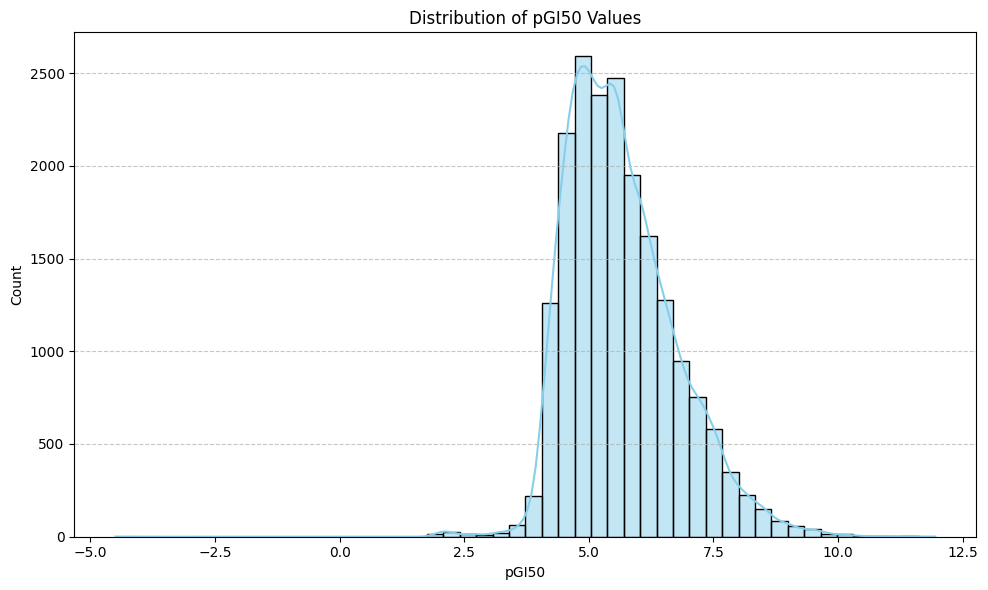


Observations from histogram: The distribution of pGI50 values is shown.
This distribution will be used to assess outliers and guide further data processing.


In [27]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=drug_df, x='pGI50_mean', bins=50, kde=True, color='skyblue')
ax.set_title('Distribution of pGI50 Values')
ax.set_xlabel('pGI50')
ax.set_ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set consistent x-axis limits
plt.xlim(x_min, x_max)

plt.tight_layout()
plt.show()

print("\nObservations from histogram: The distribution of pGI50 values is shown.")
print("This distribution will be used to assess outliers and guide further data processing.")

#### 3.7.4. Remove Outliers (IQR Method)
Outliers are removed using the Interquartile Range (IQR) method.

In [28]:
print(f"Shape before outlier removal: {drug_df.shape}")
rows_before_outlier_removal = drug_df.shape[0]

# Calculate Q1 (25th percentile) and Q3 (75th percentile) for 'pGI50'
Q1 = drug_df['pGI50_mean'].quantile(0.25)
Q3 = drug_df['pGI50_mean'].quantile(0.75)
IQR = Q3 - Q1 # Calculate the Interquartile Range

# Define the outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"pGI50 Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
print(f"Lower bound for outliers: {lower_bound:.2f}")
print(f"Upper bound for outliers: {upper_bound:.2f}")

# Filter out the outliers
cleaned_df = drug_df[(drug_df['pGI50_mean'] >= lower_bound) & (drug_df['pGI50_mean'] <= upper_bound)].copy()

rows_removed_outliers = rows_before_outlier_removal - cleaned_df.shape[0]
print(f"Number of rows identified and removed as pGI50 outliers: {rows_removed_outliers}")
print(f"Shape after outlier removal: {cleaned_df.shape}")

# Display the head of the cleaned DataFrame
print("\nFirst 5 rows of the cleaned DataFrame after outlier removal:")
display(cleaned_df.head())

Shape before outlier removal: (19329, 9)
pGI50 Q1: 4.84, Q3: 6.29, IQR: 1.45
Lower bound for outliers: 2.67
Upper bound for outliers: 8.46
Number of rows identified and removed as pGI50 outliers: 365
Shape after outlier removal: (18964, 9)

First 5 rows of the cleaned DataFrame after outlier removal:


molregno                                   canonical_smiles standard_type  \
0       148         O=c1oc2c(O)c(O)cc3c(=O)oc4c(O)c(O)cc1c4c23          GI50   
1       666  Cc1c(C)c2c(c(C)c1O)CCC(C)(COc1ccc(CC3SC(=O)NC3...          GI50   
2       696                  Cc1cc(O)nc2c3c(ccc12)OC(C)(C)C=C3          GI50   
3       717  CC(O)(CS(=O)(=O)c1ccc(F)cc1)C(=O)Nc1ccc(C#N)c(...          GI50   
4       846  CC1(C)CC(C)(C)c2cc(NC(=S)Nc3ccc([N+](=O)[O-])c...          GI50   

  standard_relation  pGI50_mean standard_units      organism target_type  \
0                 =    7.999957             nM  Homo sapiens   CELL-LINE   
1                 =    4.823909             nM  Homo sapiens   CELL-LINE   
2                 =    5.421428             nM  Homo sapiens   CELL-LINE   
3                 =    5.583359             nM  Homo sapiens   CELL-LINE   
4                 =    5.405822             nM  Homo sapiens   CELL-LINE   

   num_activities  
0               1  
1               1  
2               7  
3               1  
4               9

#### 3.7.5. Plot Histogram After Outlier Removal
A histogram of the `pGI50_mean` values is plotted *after* outlier removal, using the same axis limits as before, to visually assess the impact of the outlier removal process.

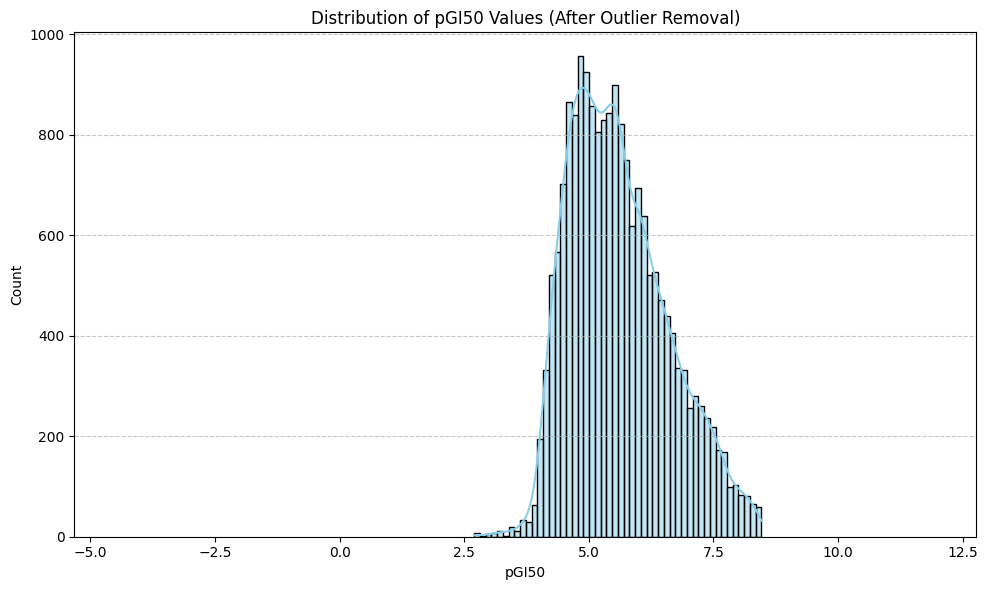


Observations from histogram:
- This histogram shows the distribution of pGI50 values after outliers have been removed.
- Compare this to the previous histogram to visually assess the impact of outlier removal.
- The distribution should now appear more confined and potentially more symmetric.


In [29]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=cleaned_df, x='pGI50_mean', bins=50, kde=True, color='skyblue')
ax.set_title('Distribution of pGI50 Values (After Outlier Removal)')
ax.set_xlabel('pGI50')
ax.set_ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set consistent x-axis limits
plt.xlim(x_min, x_max)

plt.tight_layout()
plt.show()

print("\nObservations from histogram:")
print("- This histogram shows the distribution of pGI50 values after outliers have been removed.")
print("- Compare this to the previous histogram to visually assess the impact of outlier removal.")
print("- The distribution should now appear more confined and potentially more symmetric.")

### 3.8. Perform Final Adjustments
This step involves dropping all columns except `molregno`, `smiles`, `pGI50_mean` (which will be renamed to `pGI50`).

In [ ]:
# Review the current columns
print("Current columns in cleaned_df:", cleaned_df.columns.tolist())

columns_to_drop_final = [
    'standard_type',
    'standard_relation',
    'standard_units',
    'organism',         # All 'Homo Sapiens', constant
    'target_type',      # All 'CELL-LINE', constant
    'standard_value'    # Original value, now superseded by pGI50_mean
]

final_cleaned_df = cleaned_df.drop(columns=[col for col in columns_to_drop_final if col in cleaned_df.columns], errors='ignore')

# Rename pGI50_mean to pGI50
if 'pGI50_mean' in final_cleaned_df.columns:
    final_cleaned_df.rename(columns={'pGI50_mean': 'pGI50'}, inplace=True)
    print("\nRenamed 'pGI50_mean' to 'pGI50'.")

print(f"\nShape of final cleaned DataFrame: {final_cleaned_df.shape}")
print("Final columns for saving:", final_cleaned_df.columns.tolist())
display(final_cleaned_df.head())

print("\nFinal DataFrame Info:")
final_cleaned_df.info()
print("\nFinal DataFrame Descriptive Statistics:")
display(final_cleaned_df.describe())

Current columns in cleaned_df: ['molregno', 'canonical_smiles', 'standard_type', 'standard_relation', 'pGI50_mean', 'standard_units', 'organism', 'target_type', 'num_activities']

Renamed 'pGI50_mean' to 'pGI50'.

Shape of final cleaned DataFrame: (18964, 4)
Final columns for saving: ['molregno', 'canonical_smiles', 'pGI50', 'num_activities']


molregno                                   canonical_smiles     pGI50  \
0       148         O=c1oc2c(O)c(O)cc3c(=O)oc4c(O)c(O)cc1c4c23  7.999957   
1       666  Cc1c(C)c2c(c(C)c1O)CCC(C)(COc1ccc(CC3SC(=O)NC3...  4.823909   
2       696                  Cc1cc(O)nc2c3c(ccc12)OC(C)(C)C=C3  5.421428   
3       717  CC(O)(CS(=O)(=O)c1ccc(F)cc1)C(=O)Nc1ccc(C#N)c(...  5.583359   
4       846  CC1(C)CC(C)(C)c2cc(NC(=S)Nc3ccc([N+](=O)[O-])c...  5.405822   

   num_activities  
0               1  
1               1  
2               7  
3               1  
4               9


Final DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 18964 entries, 0 to 19328
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   molregno          18964 non-null  int64  
 1   canonical_smiles  18964 non-null  object 
 2   pGI50             18964 non-null  float64
 3   num_activities    18964 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 740.8+ KB

Final DataFrame Descriptive Statistics:


molregno         pGI50  num_activities
count  1.896400e+04  18964.000000    18964.000000
mean   1.469810e+06      5.605709        5.678232
std    8.725293e+05      0.988554       11.122305
min    1.480000e+02      2.699000        1.000000
25%    5.755018e+05      4.835585        1.000000
50%    1.557706e+06      5.470846        2.000000
75%    2.281521e+06      6.236571        5.000000
max    2.881183e+06      8.462476      219.000000

### 3.9. Save Cleaned Dataset
The final cleaned and preprocessed dataset is saved to a file for subsequent use.

In [31]:
final_cleaned_df_dir = Path("../data/processed")
final_cleaned_df_dir.mkdir(parents=True, exist_ok=True) # Ensure the 'processed' directory exists

final_cleaned_df_savepath = final_cleaned_df_dir / "gi50_final_cleaned_data.csv" # A clear name for the final output

final_cleaned_df.to_csv(final_cleaned_df_savepath, index=False)
print(f"Final cleaned dataset saved to: {final_cleaned_df_savepath}")

Final cleaned dataset saved to: ..\data\processed\gi50_final_cleaned_data.csv


## 4. Close Connection to Database
This section closes the connection to the ChEMBL SQLite database, releasing resources.

In [32]:
if 'conn' in globals() and conn is not None:
    conn.close()
    print("Database connection closed.")
else:
    print("Database connection was not open or already closed.")

Database connection closed.
